In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -U albumentations

In [2]:
# import packages
from __future__ import print_function, division
import os
import math
import gc
import cv2
import time
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import numpy as np
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import torch.optim as optim 
import torch.nn.functional as F
from matplotlib import pyplot as plt
from skimage import io, transform
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [ ]:
# !cat test.zip* > ~/test.zip
# !cat training.zip* > ~/training.zip

In [ ]:
!wget "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip"
!wget "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip"
!unzip "/content/ISBI2016_ISIC_Part3_Test_Data.zip" -d "/content/"
!unzip "/content/ISBI2016_ISIC_Part3_Training_Data.zip" -d "/content/"

In [4]:
train_DataRoot = "./ISBI2016_ISIC_Part3_Training_Data"
test_DataRoot = "./ISBI2016_ISIC_Part3_Test_Data"
if not os.path.exists(train_DataRoot):
    os.makedirs(train_DataRoot)
if not os.path.exists(test_DataRoot):
    os.makedirs(test_DataRoot)

# for filename in os.listdir("./ISBI2016_ISIC_Part3_Training_Data"):
#     file_path = os.path.join("./ISBI2016_ISIC_Part3_Training_Data", filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))

In [5]:
TRAIN_DATA_PATH = '/content/gdrive/MyDrive/ELEC4010N/HW2/Train/'
TRAIN_LABEL_PATH = '/content/gdrive/MyDrive/ELEC4010N/HW2/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
TEST_DATA_PATH = '/content/gdrive/MyDrive/ELEC4010N/HW2/Test/'
TEST_LABEL_PATH = '/content/gdrive/MyDrive/ELEC4010N/HW2/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'

if not os.path.exists("./train"):
    os.makedirs("./train")
    os.makedirs("./train/benign")
    os.makedirs("./train/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/ISIC_0000000.jpg", "./train/benign/ISIC_0000000.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000000"][i], df["benign"][i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")
    
      
if not os.path.exists("./test"):
    os.makedirs("./test")
    os.makedirs("./test/benign")
    os.makedirs("./test/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Test_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg", "./test/benign/ISIC_0000003.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000003"][i], df["0.0"][i]
    label = "benign" if label == 0 else "malignant"
    shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./test/"+label+"/"+name+".jpg")

In [152]:
## Load data
root_train = './train'
root_test = './test'
TRANSFORM = transforms.Compose([
    transforms.Resize(244),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=0.5,
        std=0.5
    )
])

def get_train_test_set(batch_size=16, transform=TRANSFORM, train_dataset=None, 
                       test_dataset=None, noAugm=True):
    if noAugm:
        train_dataset = datasets.ImageFolder(root_train, transform=transform)
        test_dataset = datasets.ImageFolder(root_test, transform=transform)
        loader_train = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True
            )
        
        loader_test = torch.utils.data.DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False
            )
    else:
        print("before concat")
        print(type(train_dataset))
        print(len(train_dataset))
        Augm_train_subset = []
        Augm_test_subset = []
        UnAugm_train_dataset = datasets.ImageFolder(root_train, transform=transform)
        UnAugm_test_dataset = datasets.ImageFolder(root_test, transform=transform)
        ## Half Augm & Half UnAugm
        n_UnAugm_train = int(0.5 * len(UnAugm_train_dataset)) ## 900 / 2
        n_UnAugm_test = 199
        n_Augm_train = int(n_UnAugm_train/3)                  ## 450 / 3
        n_Augm_test = 60                                      ## 60 * 3
        print("n_UnAugm_train", n_UnAugm_train)
        print("n_UnAugm_test", n_UnAugm_test)
        print("n_Augm_train", n_Augm_train)
        print("n_Augm_test", n_Augm_test)
        ## split & combine train dataset
        UnAugm_train_subset = torch.utils.data.Subset(UnAugm_train_dataset, range(n_UnAugm_train))
        for dataset in train_dataset:
            Augm_train_subset.append(torch.utils.data.Subset(dataset, range(n_Augm_train)))
            print("len Augm_train_subset", len(Augm_train_subset[-1]))
        print("len UnAugm_train_subset", len(UnAugm_train_subset))
        train_dataset = torch.utils.data.ConcatDataset([UnAugm_train_subset, Augm_train_subset[0],
                                                        Augm_train_subset[1], Augm_train_subset[2]])
        ## split & combine test dataset
        UnAugm_test_subset = torch.utils.data.Subset(UnAugm_test_dataset, range(n_UnAugm_test))
        for dataset in test_dataset:
            Augm_test_subset.append(torch.utils.data.Subset(dataset, range(n_Augm_test)))
        test_dataset = torch.utils.data.ConcatDataset([UnAugm_test_subset, Augm_test_subset[0],
                                                        Augm_test_subset[1], Augm_test_subset[2]])
        print("after concat")
        print(type(train_dataset))
        print(len(train_dataset))


        ## data loader
        loader_train = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True
            )
        loader_test = torch.utils.data.DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True
            )
    return loader_train, loader_test

In [ ]:
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([datasets.ImageFolder(args.data + ‘/train_images’,
                                                         transform=data_transforms_A),
                                    datasets.ImageFolder(args.data + ‘/train_images’,
                                                         transform=data_transforms)]),
                                           batch_size=args.batch_size, shuffle=True, num_workers=1)


n = len(orig_set)  # total number of examples
n_test = int(0.1 * n)  # take ~10% for test
test_set = torch.utils.data.Subset(orig_set, range(n_test))  # take first 10%
train_set = torch.utils.data.Subset(orig_set, range(n_test, n))  # take the rest   

In [7]:
train_loader, test_loader = get_train_test_set()
dataloader_iter = iter(train_loader)
batch_data = next(dataloader_iter)
print(len(batch_data))
img, label = batch_data
print(img.shape)
print(label)

dataloader_iter = iter(test_loader)
batch_data = next(dataloader_iter)
print(len(batch_data))
img, label = batch_data
print(img.shape)
print(label)

2
torch.Size([16, 3, 224, 224])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1])
2
torch.Size([16, 3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [132]:
def test(model, test_loader, Loss, noAugm=True):
    model.eval()

    correct = 0
    test_loss = 0
    total = 0
    label_concat = np.arange(0)
    pred_concat = np.arange(0)
    for i, data in tqdm(enumerate(test_loader)):
        inputs, labels = data
        if not noAugm:
            inputs = inputs.to(torch.float64)
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.to(torch.float64)
            labels = labels.type(torch.cuda.LongTensor)
            # print(inputs.is_cuda)
            # print(labels.is_cuda)
            # print(inputs.dtype)
        else:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)

        loss = Loss(outputs, labels)
        pred = torch.argmax(outputs, dim=1)
        correct += torch.sum(pred == labels).item()
        pred_np = np.array(pred.cpu()).astype('float64')
        pred_concat = np.concatenate((pred_concat, pred_np))
        labels_np = np.array(labels.cpu()).astype('float64')
        label_concat = np.concatenate((label_concat, labels_np))
        test_loss += loss.item()
        total += labels.size(0)

    test_loss = test_loss / len(test_loader)
    acc_test = 100 * correct / total
    AUC = roc_auc_score(label_concat, pred_concat)
    return test_loss, acc_test, AUC

def train(model, train_loader, optimizer, Loss, noAugm=True):
    model.train()
    
    correct = 0
    total = 0
    train_loss = 0
    for i, data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        if not noAugm:
            inputs = inputs.to(torch.float64)
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.to(torch.float64)
            labels = labels.type(torch.cuda.LongTensor)
            # print(inputs.is_cuda)
            # print(labels.is_cuda)
            # print(inputs.dtype)
        else:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        
        optimizer.zero_grad()
        
        loss = Loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, prediction = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (prediction == labels).sum().item()
    train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct / total
    return model, train_loss, train_acc
    
def conv3x3(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                    padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x
Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)

In [ ]:
## load pretrained ResNet
from torchvision.models import resnet50

pre_trained = resnet50(weights="IMAGENET1K_V2").state_dict()
new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
Resnet50.load_state_dict(new_weights)

In [10]:
class Model(nn.Module):
  def __init__(self, encoder, num_classes=10):
    super(Model, self).__init__()
    self.encoder = encoder
    self.classifier = nn.Linear(2048, num_classes)
  def forward(self, x):
    x = self.encoder(x)
    x = self.classifier(x)
    return x
model = Model(Resnet50, 10)

In [11]:
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi 

Thu Mar 30 14:16:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
## train model
total_epoch = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []
AUC_list = []
time_total = 0

model = model.cuda()
lr = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
Loss = nn.CrossEntropyLoss()
        
for epoch in range(total_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, total_epoch))
    ## clear gpu cache
    gc.collect()
    torch.cuda.empty_cache()

    time_start = time.time()
    model, train_loss, train_acc = train(model, train_loader, optimizer, Loss)
    time_end = time.time()
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        
    time_duration = round(time_end - time_start, 2)
    time_total += time_duration
    
    ## clear gpu cache
    gc.collect()
    torch.cuda.empty_cache()

    ## test model
    test_loss, test_acc, auc = test(model, test_loader, Loss)
    AUC_list.append(auc)
    val_losses.append(test_loss)
    val_accs.append(test_acc)
    print("Train Loss {:.4f}, Train Accuracy {:.4f}%, Test Loss {:.4f}, Test Accuracy {:.4f}%".format(
        train_loss,
        train_acc,
        test_loss,
        test_acc
    ))

 -- Epoch 1/10


57it [01:14,  1.31s/it]
24it [00:23,  1.03it/s]


Train Loss 0.9327, Train Accuracy 75.4444%, Test Loss 0.5624, Test Accuracy 80.2111%
 -- Epoch 2/10


57it [01:05,  1.15s/it]
24it [00:23,  1.03it/s]


Train Loss 0.4640, Train Accuracy 81.2222%, Test Loss 0.4931, Test Accuracy 81.0026%
 -- Epoch 3/10


57it [01:04,  1.13s/it]
24it [00:23,  1.02it/s]


Train Loss 0.4009, Train Accuracy 83.1111%, Test Loss 0.4594, Test Accuracy 82.3219%
 -- Epoch 4/10


57it [01:04,  1.14s/it]
24it [00:22,  1.08it/s]


Train Loss 0.3966, Train Accuracy 83.4444%, Test Loss 0.4334, Test Accuracy 83.3773%
 -- Epoch 5/10


57it [01:04,  1.13s/it]
24it [00:22,  1.05it/s]


Train Loss 0.3513, Train Accuracy 85.0000%, Test Loss 0.4177, Test Accuracy 83.3773%
 -- Epoch 6/10


57it [01:04,  1.14s/it]
24it [00:25,  1.08s/it]


Train Loss 0.3236, Train Accuracy 85.0000%, Test Loss 0.4243, Test Accuracy 82.0580%
 -- Epoch 7/10


57it [01:04,  1.13s/it]
24it [00:22,  1.05it/s]


Train Loss 0.2971, Train Accuracy 87.4444%, Test Loss 0.4051, Test Accuracy 86.5435%
 -- Epoch 8/10


57it [01:05,  1.15s/it]
24it [00:23,  1.02it/s]


Train Loss 0.2785, Train Accuracy 88.4444%, Test Loss 0.4122, Test Accuracy 83.9050%
 -- Epoch 9/10


57it [01:05,  1.15s/it]
24it [00:22,  1.05it/s]


Train Loss 0.2361, Train Accuracy 89.7778%, Test Loss 0.3913, Test Accuracy 87.0712%
 -- Epoch 10/10


57it [01:04,  1.14s/it]
24it [00:22,  1.06it/s]

Train Loss 0.2151, Train Accuracy 91.3333%, Test Loss 0.4691, Test Accuracy 84.9604%


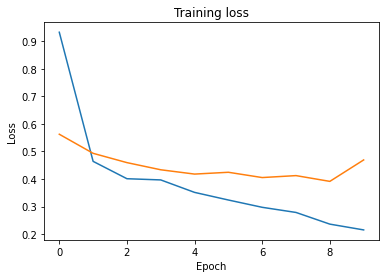

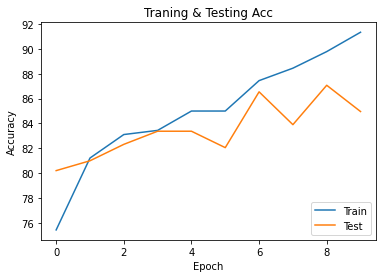

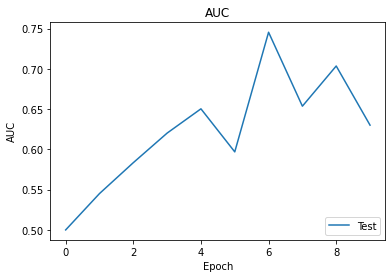

In [25]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.figure()

plt.title("Traning & Testing Acc")
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Test")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.title("AUC")
plt.plot(AUC_list, label="Test")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

In [79]:
class AugmDataSet():
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "malignant":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [72]:
import random
import albumentations as Augm
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow


BenignTrain_direc = "/content/train/benign/"
MaligTrain_direc = "/content/train/malignant/"
BenignTest_direc = "/content/test/benign/"
MaligTest_direc = "/content/test/malignant"

BenignTrain_filepaths = sorted([os.path.join(BenignTrain_direc, f) for f in os.listdir(BenignTrain_direc)])
MaligTrain_filepaths = sorted([os.path.join(MaligTrain_direc, f) for f in os.listdir(MaligTrain_direc)])
images_filepaths = [*BenignTrain_filepaths, *MaligTrain_filepaths]
TrainImages_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

BenignTest_filepaths = sorted([os.path.join(BenignTest_direc, f) for f in os.listdir(BenignTest_direc)])
MaligTest_filepaths = sorted([os.path.join(MaligTest_direc, f) for f in os.listdir(MaligTest_direc)])
images_filepaths = [*BenignTest_filepaths, *MaligTest_filepaths]
TestImages_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(TrainImages_filepaths)
random.shuffle(TestImages_filepaths)
print(len(TrainImages_filepaths), len(TestImages_filepaths))

900 379


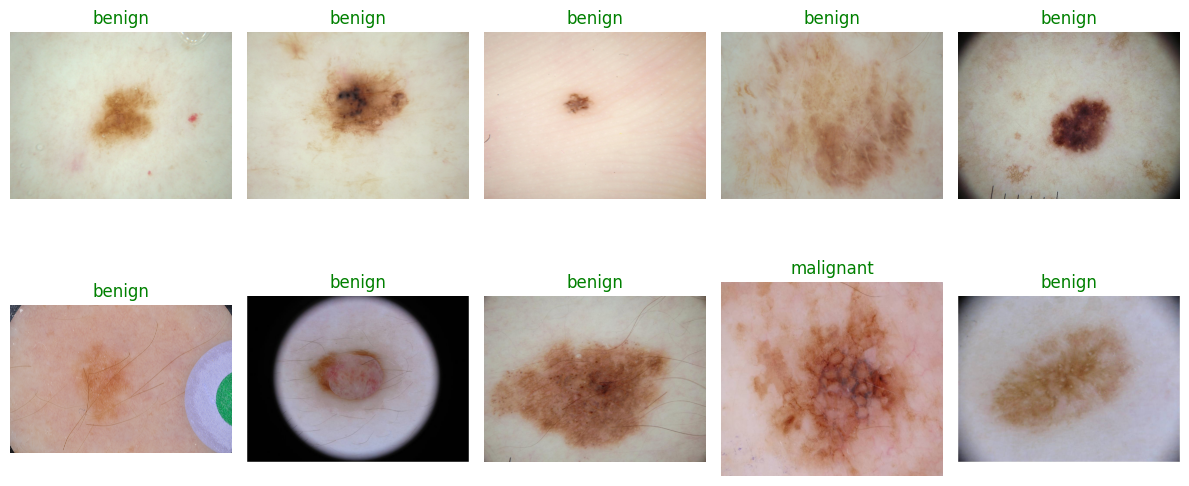

In [60]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(TestImages_filepaths[:10])

In [ ]:
# Flipping
GEO = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(244, 244),
    Augm.RandomCrop(width=224, height=224),
    Augm.HorizontalFlip(p=1),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])
GEO_train_dataset = AugmDataSet(images_filepaths=TrainImages_filepaths, transform=GEO)
GEO_test_dataset = AugmDataSet(images_filepaths=TestImages_filepaths, transform=GEO)
# Color distortion
COL = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(244, 244),
    Augm.RandomCrop(width=224, height=224),
    Augm.augmentations.transforms.ColorJitter(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])
COL_train_dataset = AugmDataSet(images_filepaths=TrainImages_filepaths, transform=COL)
COL_test_dataset = AugmDataSet(images_filepaths=TestImages_filepaths, transform=COL)
# PCA
PCA = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(244, 244),
    Augm.RandomCrop(width=224, height=224),
    Augm.augmentations.transforms.FancyPCA(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])
PCA_train_dataset = AugmDataSet(images_filepaths=TrainImages_filepaths, transform=PCA)
PCA_test_dataset = AugmDataSet(images_filepaths=TestImages_filepaths, transform=PCA)

train_loader, test_loader = get_train_test_set(train_dataset=[GEO_train_dataset,COL_train_dataset,PCA_train_dataset],
                                               test_dataset=[GEO_test_dataset,COL_test_dataset,PCA_test_dataset], noAugm=False)
print(type(train_loader))

## train model
total_epoch = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []
AUC_list = []
time_total = 0

model = model.cuda()
lr = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
Loss = nn.CrossEntropyLoss()
        
# for epoch in range(total_epoch):
#     print(" -- Epoch {}/{}".format(epoch + 1, total_epoch))
#     ## clear gpu cache
#     gc.collect()
#     torch.cuda.empty_cache()

#     time_start = time.time()
#     model, train_loss, train_acc = train(model, train_loader, optimizer, Loss, noAugm=False)
#     time_end = time.time()
        
#     train_losses.append(train_loss)
#     train_accs.append(train_acc)
        
#     time_duration = round(time_end - time_start, 2)
#     time_total += time_duration
    
#     ## clear gpu cache
#     gc.collect()
#     torch.cuda.empty_cache()

#     ## test model
#     test_loss, test_acc, auc = test(model, test_loader, Loss, noAugm=False)
#     AUC_list.append(auc)
#     val_losses.append(test_loss)
#     val_accs.append(test_acc)
#     print("Train Loss {:.4f}, Train Accuracy {:.4f}%, Test Loss {:.4f}, Test Accuracy {:.4f}%".format(
#         train_loss,
#         train_acc,
#         test_loss,
#         test_acc
#     ))

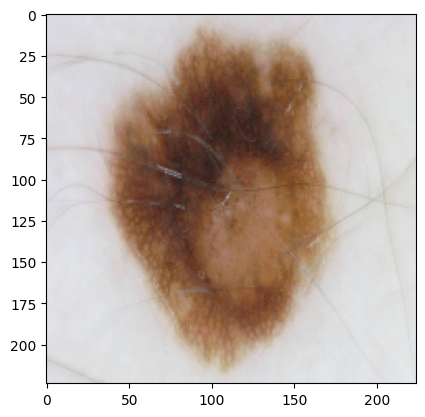

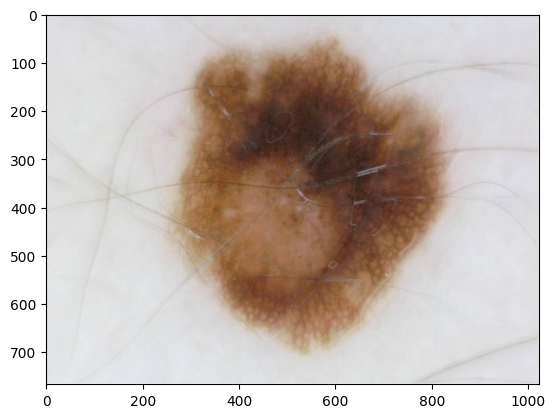

In [166]:
GEO = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(244, 244),
    Augm.RandomCrop(width=224, height=224),
    Augm.HorizontalFlip(p=1),
    Augm.RandomBrightnessContrast(p=0.1),
])

# Show example
image = mpimg.imread("/content/ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg")
# Augment an image
transformed = GEO(image=image)
transformed_image = transformed["image"]

plt.figure()
imgplot = plt.imshow(transformed_image)
plt.show(imgplot)

plt.figure()
imgplot1 = plt.imshow(image)
plt.show(imgplot1)

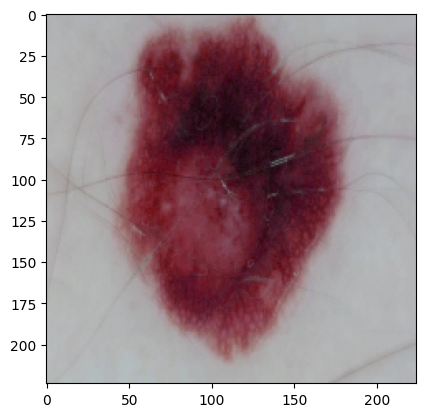

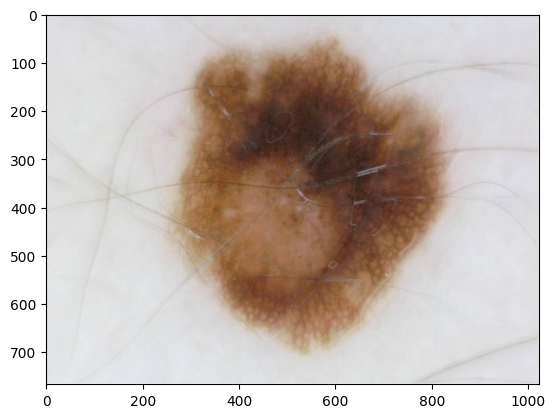

In [167]:
# Color distortion
color_transform = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(244, 244),
    Augm.RandomCrop(width=224, height=224),
    Augm.augmentations.transforms.ColorJitter(),
    Augm.RandomBrightnessContrast(p=0.1),
])

image = mpimg.imread("/content/ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg")

# Augment an image
transformed = color_transform(image=image)
transformed_image = transformed["image"]

plt.figure()
imgplot = plt.imshow(transformed_image)
plt.show(imgplot)

plt.figure()
imgplot1 = plt.imshow(image)
plt.show(imgplot1)

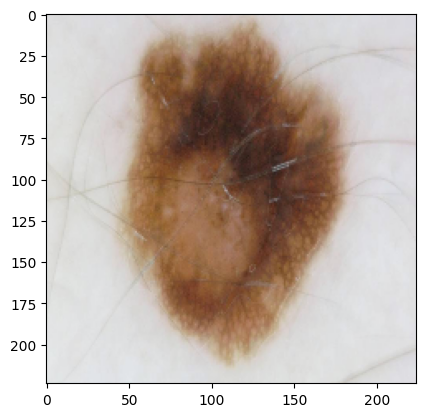

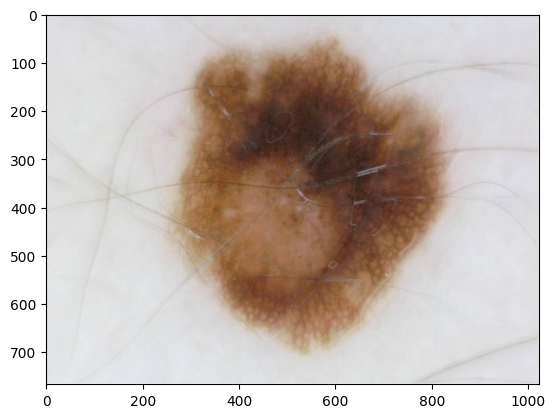

In [168]:
# PCA
PCA_transform = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(244, 244),
    Augm.RandomCrop(width=224, height=224),
    Augm.augmentations.transforms.FancyPCA(),
    Augm.RandomBrightnessContrast(p=0.1),
])

image = mpimg.imread("/content/ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg")

# Augment an image
transformed = PCA_transform(image=image)
transformed_image = transformed["image"]

plt.figure()
imgplot = plt.imshow(transformed_image)
plt.show(imgplot)

plt.figure()
imgplot1 = plt.imshow(image)
plt.show(imgplot1)